# Лабораторная работа №9. Понижение размерности. Отбор признаков. Извлечение признаков

In [2]:
import pandas as pd
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import numpy as np
import pandas
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

## Предобработка данных

In [3]:
df = pd.read_csv(r"../data/DataSet3-v8.csv")

# удаление пропусков
df['engine_capacity']=df['engine_capacity'].fillna(0)
# удаление дублей
df = df.drop_duplicates().reset_index(drop=True)
# перевод категориал. данных в бинар.
bn = BinaryEncoder()
df_bn_obj = bn.fit_transform(df.select_dtypes(include=['object','bool'])).astype('int8')
df_num = df.select_dtypes(exclude=['object', 'bool'])
df = pd.concat([df_num, pd.DataFrame(df_bn_obj)], axis=1)
# EDA
outlier = df[['odometer_value', 'year_produced', 'engine_capacity', 'price_usd', 'number_of_photos', 'up_counter', 'duration_listed']]
Q1 = outlier.quantile(0.25)
Q3 = outlier.quantile(0.75)
IQR = Q3-Q1
df_filtered = outlier[~((outlier < (Q1 - 1.5 * IQR)) |(outlier > (Q3 + 1.5 * IQR))).any(axis=1)]
index_list = list(df_filtered.index.values)
df_filtered = df[df.index.isin(index_list)]

df_reg = df_filtered

# Разбиение на тренеровочную и тестовую выборки
y_reg = df_reg["price_usd"]
x_reg = df_reg.drop(["price_usd"], axis=1)

In [4]:
data = pd.read_csv(r"../data/weatherAUS.csv")

# Удаление пропусков
data.dropna(inplace=True,ignore_index=True)
# Перевод категориал. данных в бинарные
f = lambda x : str(x)[5:7]
data['Date'] = data['Date'].transform(f).astype(int)

data['RainToday'] = data['RainToday'].replace("Yes", 1)
data['RainToday'] = data['RainToday'].replace("No", 0)
data['RainTomorrow'] = data['RainTomorrow'].replace("Yes", 1)
data['RainTomorrow'] = data['RainTomorrow'].replace("No", 0)

bn = BinaryEncoder()
data_category = bn.fit_transform(data.select_dtypes(include=['object'])).astype(int)
data_num = data.select_dtypes(exclude=['object'])
data = pd.concat([data_num, pd.DataFrame(data_category)], axis=1)
pd.set_option('display.max_columns', None)
# Балансировка данных
df_0 = data.loc[data['RainTomorrow']==0]
df_0 = df_0.sample(len(data.loc[data['RainTomorrow']==1]))
df_conc = pd.concat([data.loc[data['RainTomorrow']==1], df_0])

df_class = df_conc

# Разбиение на тренеровочную и тестовую выборки
x_class=df_class.drop(['RainTomorrow'],axis=1)
y_class=df_class['RainTomorrow']

## Функции для разделения на тестовую и тренировочную выборки, их обучения и вывода метрик

In [5]:
def test_class(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
  bag = BaggingClassifier().fit(X_train, y_train)
  print(classification_report(y_test, bag.predict(X_test)))

In [6]:
test_class(x_class, y_class)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4081
           1       0.80      0.76      0.78      4121

    accuracy                           0.78      8202
   macro avg       0.78      0.78      0.78      8202
weighted avg       0.78      0.78      0.78      8202



In [7]:
def test_reg(X, y):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
  bag = LinearRegression().fit(x_train, y_train)
  print(f'MAE: {mean_absolute_error(y_test, bag.predict(x_test))}')
  print(f'MSE: {mean_squared_error(y_test, bag.predict(x_test))}')
  print(f'RMSE: {sqrt(mean_squared_error(y_test, bag.predict(x_test)))}')
  print(f'MAPE: {sqrt(mean_absolute_percentage_error(y_test, bag.predict(x_test)))}')
  print(f'R^2: {bag.score(x_test, y_test)}')

In [8]:
test_reg(x_reg, y_reg)

MAE: 1376.9571212750106
MSE: 3437830.02872882
RMSE: 1854.138621767213
MAPE: 0.7557809752902392
R^2: 0.8093320928539127


## Variance Treshold

Отбираем признаки с высокой дисперсией

In [9]:
# параметр - порог значения дисперсии
# будут отобраны только те признаки, у которых дисперсия выше
vt = VarianceThreshold(50)
X_vt = vt.fit_transform(x_class)

print(x_class.shape)
print(X_vt.shape)

X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
test_class(X_vt, y_class)

(24854, 38)
(24854, 8)
              precision    recall  f1-score   support

           0       0.74      0.81      0.77      4092
           1       0.79      0.72      0.75      4110

    accuracy                           0.76      8202
   macro avg       0.76      0.76      0.76      8202
weighted avg       0.76      0.76      0.76      8202



In [10]:
vt = VarianceThreshold(0.5)
X_vt = vt.fit_transform(x_reg)

print(x_reg.shape)
print(X_vt.shape)

X_vt = pd.DataFrame(X_vt, columns=vt.get_feature_names_out())
test_reg(X_vt, y_reg)

(29226, 58)
(29226, 5)
MAE: 1889.9999936369609
MSE: 6166766.254163571
RMSE: 2483.2974558364067
MAPE: 1.3010500964792073
R^2: 0.6555350190149877


При параметре 0.1 - 49 признаков и р2 0.8, при 0.2 - 35 приз и 0,75 р2, при >=0.5 - 5 признаков и 0,65 р2

## SelectKBest

Для каждого признака оценивается степень его влияния на целевую переменную

In [11]:
skb = SelectKBest(k=10)
X_skb = skb.fit_transform(x_class, y_class)

print(x_class.shape)
print(X_skb.shape)

X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
test_class(X_skb, y_class)

(24854, 38)
(24854, 10)
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      4137
           1       0.79      0.74      0.76      4065

    accuracy                           0.77      8202
   macro avg       0.77      0.77      0.77      8202
weighted avg       0.77      0.77      0.77      8202



In [12]:
skb = SelectKBest(k=25)
X_skb = skb.fit_transform(x_reg, y_reg)

print(x_reg.shape)
print(X_skb.shape)

X_skb = pd.DataFrame(X_skb, columns=skb.get_feature_names_out())
test_reg(X_skb, y_reg)

(29226, 58)
(29226, 25)
MAE: 1429.077881662127
MSE: 3721776.4471766534
RMSE: 1929.1906197098963
MAPE: 0.8181435108716912
R^2: 0.7885321203214983


## RFE

Рекурсивный отбор признаков

In [13]:
tree = DecisionTreeClassifier().fit(x_class, y_class)

rfe = RFE(estimator=tree, n_features_to_select=10).fit(x_class, y_class)
X_rfe = pd.DataFrame(rfe.transform(x_class), columns=rfe.get_feature_names_out())

print(x_class.shape)
print(X_rfe.shape)

test_class(X_rfe, y_class)

(24854, 38)
(24854, 10)
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      4145
           1       0.80      0.76      0.78      4057

    accuracy                           0.78      8202
   macro avg       0.78      0.78      0.78      8202
weighted avg       0.78      0.78      0.78      8202



In [14]:
tree = DecisionTreeRegressor().fit(x_reg, y_reg)

rfe = RFE(estimator=tree, n_features_to_select=25).fit(x_reg, y_reg)
X_rfe = pd.DataFrame(rfe.transform(x_reg), columns=rfe.get_feature_names_out())

print(x_reg.shape)
print(X_rfe.shape)

test_reg(X_rfe, y_reg)

(29226, 58)
(29226, 25)
MAE: 1456.164026696836
MSE: 3833929.433691687
RMSE: 1958.042245124371
MAPE: 1.0715419303747182
R^2: 0.7904137709889091


## PCA

Метод главных компонент

In [15]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(x_class, y_class)

print(x_class.shape)
print(X_pca.shape)

test_class(X_pca, y_class)
# посмотрим сколько информации сохранилось
sum(pca.explained_variance_ratio_)

(24854, 38)
(24854, 8)
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      4076
           1       0.78      0.73      0.76      4126

    accuracy                           0.76      8202
   macro avg       0.76      0.76      0.76      8202
weighted avg       0.76      0.76      0.76      8202



0.9702814225437326

In [16]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(x_reg, y_reg)

print(x_reg.shape)
print(X_pca.shape)

test_reg(X_pca, y_reg)
sum(pca.explained_variance_ratio_)

(29226, 58)
(29226, 8)
MAE: 1564.6147269631515
MSE: 4371895.14535702
RMSE: 2090.907732387305
MAPE: 0.9994468387578177
R^2: 0.7598323454379713


0.9999999994631491

## tSNE, Isomap

Нелинейные методы выделения признаков

In [17]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(x_class)

print(x_class.shape)
print(X_tsne.shape)

test_class(X_tsne, y_class)

(24854, 38)
(24854, 2)
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      4123
           1       0.77      0.73      0.75      4079

    accuracy                           0.75      8202
   macro avg       0.76      0.75      0.75      8202
weighted avg       0.75      0.75      0.75      8202



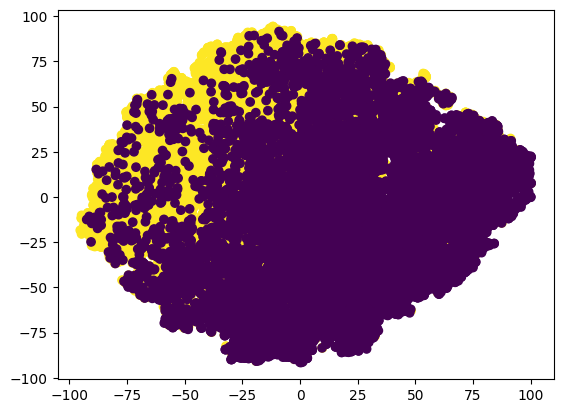

In [18]:
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_class)

In [19]:
tsne_reg = TSNE(n_components=2)
X_tsner = tsne_reg.fit_transform(x_reg)

print(x_reg.shape)
print(X_tsner.shape)

test_reg(X_tsner, y_reg)

(29226, 58)
(29226, 2)
MAE: 2958.630799990482
MSE: 14469260.462826211
RMSE: 3803.848112481124
MAPE: 1.6481539456105077
R^2: 0.17764810384697216


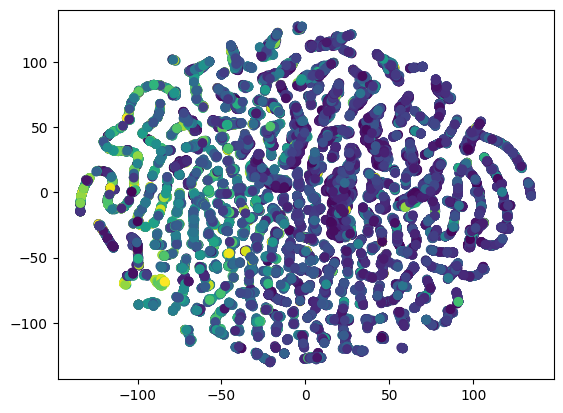

In [20]:
plt.scatter(X_tsner[:,0], X_tsner[:,1], c=y_reg)

In [21]:
tsne_reg = TSNE(n_components=3)
X_tsner = tsne_reg.fit_transform(x_reg)

print(x_reg.shape)
print(X_tsner.shape)

test_reg(X_tsner, y_reg)

(29226, 58)
(29226, 3)
MAE: 2994.8355088898065
MSE: 14736848.421555161
RMSE: 3838.860302427683
MAPE: 1.6144013777546304
R^2: 0.1669805059735665


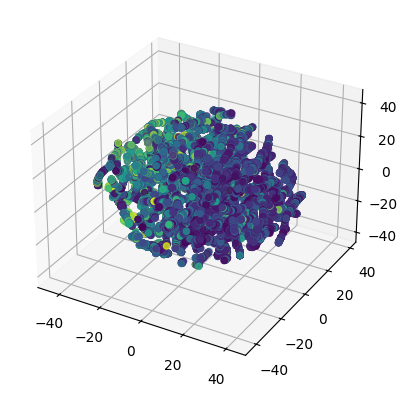

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_tsner[:,0], X_tsner[:,1], X_tsner[:,2], c=y_reg)

## Isomap

In [23]:
x = x_class
isomap = Isomap(n_components=2)
X_iso = isomap.fit_transform(x)

print(x.shape)
print(X_iso.shape)

test_class(X_iso, y_class)


(24854, 38)
(24854, 2)
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      4057
           1       0.74      0.68      0.71      4145

    accuracy                           0.72      8202
   macro avg       0.72      0.72      0.72      8202
weighted avg       0.72      0.72      0.72      8202



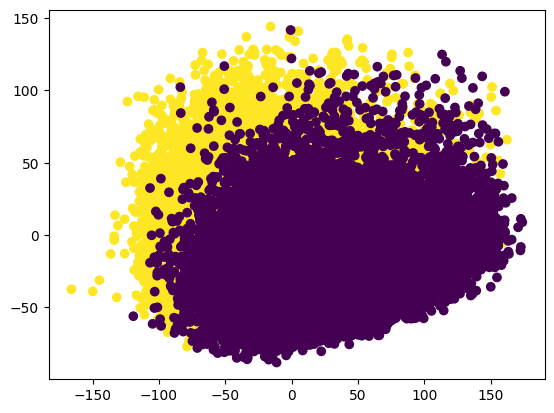

In [24]:
plt.scatter(X_iso[:,0], X_iso[:,1], c=y_class)

In [33]:
from scipy import sparse
sA = sparse.lil_matrix(x_reg[:10000])
#sB = sparse.lil_matrix(y_reg)

In [35]:
isomapr = Isomap(n_components=2)
X_isor = isomapr.fit_transform(sA)

print(x_reg[:10000].shape)
print(X_isor.shape)

test_reg(X_isor, y_reg[:10000])

c:\Users\User\ml-labs\venv\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 196 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\User\ml-labs\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(10000, 58)
(10000, 2)
MAE: 2636.864746461067
MSE: 12014772.470915828
RMSE: 3466.23318184392
MAPE: 1.3403260750986492
R^2: 0.1562789069032352


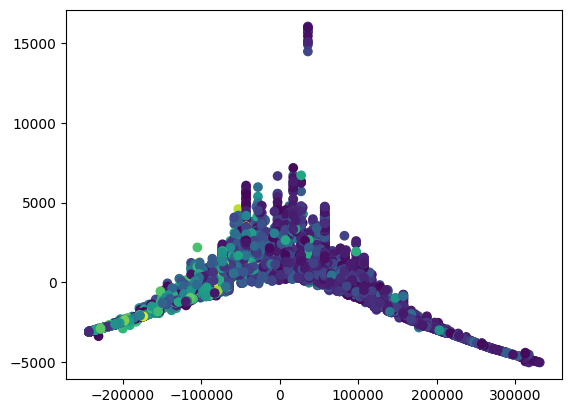

In [39]:
plt.scatter(X_isor[:,0], X_isor[:,1], c=y_reg[:10000])

In [40]:
isomapr = Isomap(n_components=3)
X_isor = isomapr.fit_transform(sA)

print(x_reg[:10000].shape)
print(X_isor.shape)

test_reg(X_isor, y_reg[:10000])

c:\Users\User\ml-labs\venv\lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 196 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\User\ml-labs\venv\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(10000, 58)
(10000, 3)
MAE: 2586.487070350298
MSE: 11534630.776295751
RMSE: 3396.2671827015834
MAPE: 1.2912735176852794
R^2: 0.1895652475970958


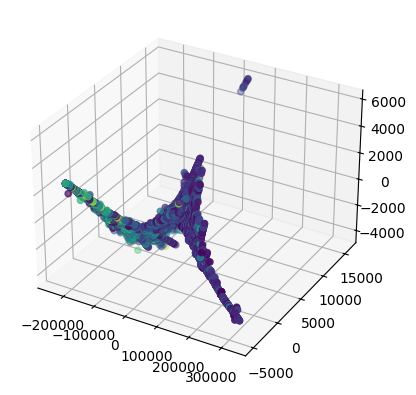

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_isor[:,0], X_isor[:,1], X_isor[:,2], c=y_reg[:10000])